## Demo on how to create a HDF5 dataset from raw images

### Contents

1. Prepare your data
2. Define all expected common parameters
3. Call generate_h5(...) to generate HDF5 dataset file
4. Call load_all_data(...) to extract the data as np.array objects into your python env
5. Check on the shape or content of the various np.array
6. Check to visualize a randomly chosen image
7. Sample code for Mini-batch access for bigger dataset
8. References

In [1]:
from random import shuffle
import os
import glob
import scipy
from scipy import ndimage
import numpy as np
import h5py
import matplotlib.pyplot as plt
from data_util import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

/Users/kelvinchan/Documents/TensorFlowStuff/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### 1. Prepare your data
Put all images with the same label into each separate folder. Name the folder
with the name of the target class. For example, if you have a binary classification 
task to identify cats vs non-cats. Put all your cats photo into a folder named "cat" and
all the non-cats photos into another folder named "non-cat". We will use this as example in this notebook.

For multi-class classification with classes named "A", "B", "C", and "D", create 4 folders with those
names and place your images under each.

#### 2. Define all expected common parameters
* __data_path__ is the root directory containing all the folders holding images of each class (see above).
* __shuffled_data__ is a boolean to determine if we should shuffle the data before saving into h5 file
* __height, width__ are the resized height and width. It is assumed that in general, your photos may have different height and width, and they will have to be resized to these fixed values.
* __data_order__ can either be 'tf' or 'th' (tensorflow vs. theano). I have only tested 'tf' for now, so just stick with that. The only difference I am aware of is 'tf' uses "channel last" with shape (m, h, w, c) and 'th' uses "channel first" with shape (m, c, h, w)
* __outfile_path__ is the name of the output HDF5 file name.
* __labels_to_classes_dictionary__ is a python dictionary with numeric string as key and the name of the class as values. E.g. {"0": "non-cat", "1": "cat"}

In [2]:
shuffle_data = True
data_order = 'tf'      # channel last

# root directory where the data is stored.
data_path = '.'   # current directory

# resize dimensions
height = 224      
width = 224

# the hdf5 file to write to
outfile_path = "train_" + str(height) + "_" + str(width) + ".hdf5"

target_label_dictionary = {"0": "non-cat", "1": "cat"}

#### 3. Call generate_h5(...) to generate HDF5 dataset file
generate_h5 takes a few argument. Please see data_util.py for all details. Most of the important arguments are explained in Part 2 above. The method will save a file with name __outfile_path__ that is an HDF5 dataset.

In [3]:
generate_h5(data_path, labels_to_classes_dictionary=target_label_dictionary, 
            outfile_path=outfile_path, resize_height=height, resize_width=width, 
            train_dev_test_ratio=[0.6, 0.2, 0.2])

#### 4. Call load_all_data(...) to extract the data as np.array objects into your python env

In [4]:
train_set_x_orig, train_set_y_orig, dev_set_x_orig, dev_set_y_orig, test_set_x_orig, test_set_y_orig, classes = load_all_data(outfile_path)

#### 5. Check on the shape or content of the various np.array

In [5]:
print("X_train shape: " + str(train_set_x_orig.shape))
print("Y_train shape: " + str(train_set_y_orig.shape))
print("X_dev shape: " + str(dev_set_x_orig.shape))
print("Y_dev shape: " + str(dev_set_y_orig.shape))
print("X_test shape: " + str(test_set_x_orig.shape))
print("Y_test shape: " + str(test_set_y_orig.shape))

print("Classes are: " + str(classes))

X_train shape: (13, 224, 224, 3)
Y_train shape: (13, 1)
X_dev shape: (4, 224, 224, 3)
Y_dev shape: (4, 1)
X_test shape: (5, 224, 224, 3)
Y_test shape: (5, 1)
Classes are: ['non-cat' 'cat']


#### 6. Check to visualize a randomly chosen image

cat


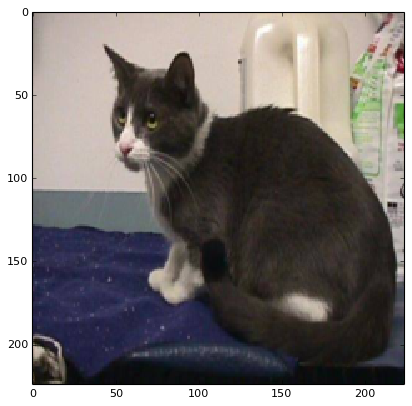

In [6]:
# Randomly visualize some X

plt.figure(figsize = (6, 6))
index = np.random.randint(len(train_set_y_orig))
print(target_label_dictionary[str(train_set_y_orig[index][0])])
plt.imshow(train_set_x_orig[index])

#### 7. Sample code for Mini-batch access for bigger dataset

1 / 1
1 [0. 1.]


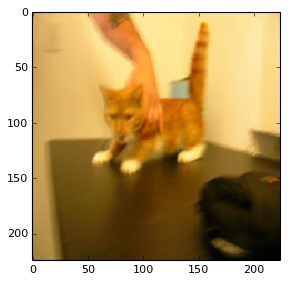

In [7]:
from math import ceil

hdf5_file = h5py.File(outfile_path, "r")

batch_size = 32
train_size = hdf5_file["train_set_x"].shape[0]
num_of_classes = len(classes)

# create list of batches
batches_list = list(range(int(ceil(float(train_size) / batch_size))))
shuffle(batches_list)

for n, i in enumerate(batches_list):
    i_s = i * batch_size  # index of the first image in this batch
    i_e = min([(i + 1) * batch_size, train_size])  # index of the last image in this batch
    
    # read batch images and remove training mean
    images = hdf5_file["train_set_x"][i_s:i_e, ...]

    # read labels and convert to one hot encoding
    labels = hdf5_file["train_set_y"][i_s:i_e]
    labels_one_hot = np.zeros((labels.shape[0], num_of_classes))
    labels_one_hot[np.arange(labels.shape[0]), labels] = 1
    
    print n+1, '/', len(batches_list)
    print labels[0], labels_one_hot[0, :]
    plt.imshow(images[0])
    plt.show()
    
    if n == 5:  # break after 5 batches
        break

hdf5_file.close()

#### Conclusion

You can now collect your own images with their own classes. Create a folder for each class and place all images belonging to that class under it. Edit and re-run this notebook. Then you can start using the h5 file and numpy data output and try your own experiments with the same code in some programming exercise in the Deep Learning Specialization on Coursera.

#### References:
* Notation and format inspired by Deep Learning Specialization from Coursera/deeplearning.ai. 
* http://machinelearninguru.com/deep_learning/data_preparation/hdf5/hdf5.html
* https://docs.scipy.org/doc/
* The few sample photos come from https://www.kaggle.com/c/dogs-vs-cats